Time series prediction with RNN
===============================
On va apprendre l'enchainement des valeurs d'une fonction.  
L'apprentissage se fera à partir de série de valeurs \[ y0, y1, ..., yn\]  
Objectif : deviner yn+1

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

import math
import random
import os
import math

import deepmods.notebook as ooo

ooo.init(id='21.3', save_figs=True)


Deepmod by pjluc 2019
  Version          : 0.4.1
  Run time         : Monday 16 September 2019, 16:02:27
  Run directory    : ./run/lab-21.3
  Save figs        : True
  Matplotlib style : deepmods/talk.mplstyle
  Hide warning     : True

TensorFlow version :  1.14.0
Keras version      :  2.2.4-tf

Init done.


In [2]:
# Usefull functions, can be hide

# ------ Numpy options
#
np.set_printoptions(precision=3)


def reset_all(seed=37):
    tf.set_random_seed(seed)
    np.random.seed(seed)
    tf.reset_default_graph()
    

def show_data(t,X,y, save_as='data'):
    # i = random.randint(0, (t_max-t_min)/resolution -n_steps) 
    i = random.randint(t_test/resolution, t_max/resolution -n_steps) 
    ts = t[i:i+n_steps]
    Xs = X[0,i:i+n_steps,0]

    fig, (ax1,ax2) = plt.subplots(2,1, sharey=False, sharex=False)
    fig.set_size_inches(16,12)
    fig.subplots_adjust(wspace=.1,hspace=.25)

    ax1.plot(t,  X[0,:,0],    linewidth=2, linestyle='-',  color='steelblue')
    ax1.plot(ts, Xs,          linewidth=2, linestyle='-',  color='salmon')
    ax1.axvline(x=t_train, linestyle='--', linewidth=2, color='red')
    ax1.set_title("Time function")
    ax1.set_xlabel('time')
    ax1.set_xticks([])

    ax2.plot(ts[:-1], Xs[:-1], linewidth=1, linestyle='-',  color='steelblue')
    ax2.plot(ts[:-1], Xs[:-1], 'o', markersize=8, color='steelblue')
    ax2.plot(ts[-2:], Xs[-2:],  '--',linewidth=1,  color='steelblue')
    ax2.plot(ts[-1],  Xs[-1],  'o', markersize=7, color='red')
    ax2.set_title("Time function")
    ax2.set_xlabel('time')
    ax2.set_xticks([])
    
    ooo.save_fig(save_as)
    plt.show()

    
def show_predictions1(n, X,y, y_pred, width=8, height=3, save_as='predictions_short'):

    t=np.arange(n_steps+1)

    columns = 2

    rows = math.ceil(n_series/columns)
    fig  = plt.figure(figsize=(columns*width, rows*(height+0.15)))
    fig.subplots_adjust(wspace=0.05,hspace=0.1)
    n=1
    for i in range(n_series):
        ax=fig.add_subplot(rows, columns, n)
        n+=1
        ax.plot(t[:-1],  X_new[i,:,0],    '-',  linewidth=1, color='steelblue')               # série donnée (connue)
        ax.plot(t[-2:],  y_new[i,-2:,0],  '--', linewidth=1, color='steelblue')               # sequence attendue (inconnue)
        ax.plot(t[1:],   y_pred[i,:,0],   'o',  fillstyle='none',  markersize=8, color='red') # réponse du réseau
        ax.plot(t[-1],   y_pred[i,-1,0],  'o',  fillstyle='full',  markersize=8, color='red') # ce qui nous interesse
        ax.set_yticks([])
        ax.set_xticks([])
    ooo.save_fig(save_as)
    plt.show()
    
    
def show_predictions2(n_series, X,y,y_pred, n_pred, columns=1, width=12, height=3, save_as='predictions_long'):

    t=np.arange(n_steps+n_pred)

    rows = math.ceil(n_series/columns)
    fig  = plt.figure(figsize=(columns*width, rows*(height+0.15)))
    fig.subplots_adjust(wspace=0.05,hspace=0.1)
    n=1
    for i in range(n_series):
        ax=fig.add_subplot(rows, columns, n)
        n+=1
        y=sequences[i]
        ax.plot(t[:n_steps],   X_new[i,:n_steps,0],      '-',  linewidth=1, color='steelblue')
        ax.plot(t[n_steps-1:], X_new[i,n_steps-1:,0],  '--', linewidth=1, color='steelblue')
        ax.plot(t[:n_steps],   y[:n_steps], 'o', fillstyle='none',  markersize=8, color='red')
        ax.plot(t[n_steps:],   y[n_steps:], 'o', fillstyle='full',  markersize=8, color='red')
        ax.set_yticks([])
        ax.set_xticks([])
    ooo.save_fig(save_as)
    plt.show()    

    
            
def show_generatives(X, sequence1, sequence2, width=14, height=10, save_as='generatives'):
    t  = np.arange(t_min, t_train,   resolution)

    fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharey=False, sharex=False)
    fig.set_size_inches(width,height)
    fig.subplots_adjust(wspace=.1,hspace=.4)

    ax1.plot(t,  sequence1,    linewidth=2, linestyle='-',  color='steelblue')
    ax1.plot(t[0:n_steps],  sequence1[0:n_steps],    linewidth=2, linestyle='-',  color='salmon')
    ax1.set_title("Generative sequence from [0]")
    ax1.set_xlabel('time')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2.plot(t,  sequence2,    linewidth=2, linestyle='-',  color='steelblue')
    ax2.plot(t[0:n_steps],  sequence2[0:n_steps],    linewidth=2, linestyle='-',  color='salmon')
    ax2.set_title("Generative sequence from [sample]")
    ax2.set_xlabel('time')
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax3.plot(t,  X_new[0,:,0],    linewidth=2, linestyle='-',  color='salmon')
    ax3.set_title("Initial signal")
    ax3.set_xlabel('time')
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    ooo.save_fig(save_as)
    plt.show()

In [3]:
# ----- Données temporelles
#
t_min           = 0         # Intervalle d'apprentissage : [ t_min, t_train]
t_train         = 30
t_test          = 30        # Intervalle de test         : [t_test, t_max]
t_max           = 100     
resolution      = 0.1       # Granularité

# ----- Model
#
n_steps         = 20        # taille des séries
n_inputs        = 1         # taille des vecteurs pour chaque valeur
n_neurons       = 100       # nombre de neurones
n_layers        = 1         # Nombre de couches
n_outputs       = 1         # nombre de vecteurs à prévoir
learning_rate   = 0.01

# ----- Entrainement
#
n_iterations = 1200
batch_size   = 50

In [4]:
     
def time_series(T):
    """
    Renvois une liste de valeurs
    Args:
        T : Liste de temps, T=[ t0, t1, t2, ..., tn]
    return:
        Liste de valeurs = [ y0, y1, y2, ..., yn]
    """
    # T est une matrice où chaque ligne contient une série [t0,t1,t2,...,tn]
    # Renvois une matrice avec les valeurs
    #
    a1,a2,a3,a4,a5 = 2,     3/5,   7/9, 13/11, 0
    b1,b2,b3,b4,b5 = 37/19, 19/5,  7/3, 17/5,  0
    
    return a1*np.sin(T*b1) + a2*np.cos(T*b2) + a3*np.sin(T*b3) + a4*np.cos(T*b4)


def get_batch(batch_size, t1, t2, n_steps):
    """
    Renvois un ensembles de séries X,Y pour l'apprentissage

    Args:
        batch_size (int)  : Nombre de séries
        t1        (float) : time min des séres
        t2        (float) : time max des séries
        n_steps    (int)  : Taille des séries
    Returns:
        (X,y) : Séries 
    """
    # 
    # On pioche un ensemble de n dates (n=batch_size)
    # Ces dates seront des points de départ pour les séries
    # t0 + intervalle ne doit pas dépasser t_max
    # t0 est une matrice de batch_size lignes, avec 1 colonne
    # t0 est compris dans l'intervalle [t1,t2]
    #
    T0 = t1 + np.random.rand(batch_size, 1) * (t2 - t1 - n_steps * resolution)

    # On complète chaque ligne de la matrice avec les ti
    # pour chaque ligne :  [t0] -> [t0,t1,t2,...,ti,...tn]
    #
    Ts = T0 + np.arange(0., n_steps + 1) * resolution

    # On calcul l'ensemble des valeurs et on renvoie
    # les séries d'apprentissage : X sur [t0,...,tn-1]
    # les séries complétées :      Y sur [t1,...,tn]
    #
    # Le format est :
    #   X comporte un ensemble de séries :          X = [ série1, série2, serie3, ...]
    #     Chaque serie est un ensemble de vecteur :   série = [ vecteur1, vecteur2, vecteur3, ...]
    #        Chaque vecteur comporte des composantes :   vecteur=[ x, y, z, ...]
    #
    # Dans notre cas, nos vecteurs n'ont qu'une seule composante : vecteur=[x]
    #  
    # Calcul des séries
    Ys = time_series(Ts)
    # Découpage X,y
    X = Ys[:, :-1].reshape(-1, n_steps, 1)
    y = Ys[:, 1:].reshape(-1, n_steps, 1)
    return X,y

### Données temporelles
Nous avons une fonction temporelle inconnue.
A partir d'une courte séquence, nous souhaitons avoir la suite (point rouge)

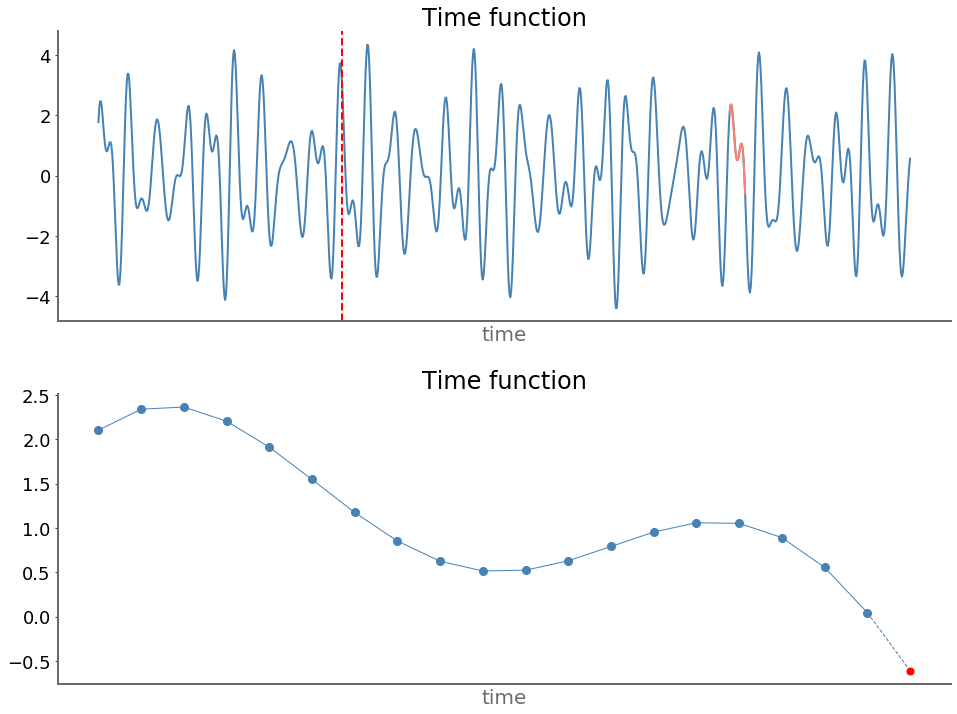

In [5]:
t       = np.arange(t_min, t_max,  resolution)
X,y     = get_batch(1, t_min,t_max, t.size)

show_data(t,X,y)

### Creation du model

In [6]:
reset_all()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs],  name='X')   # n_steps vecteurs de n_inputs éléments
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs], name='y')   # n_steps vecteurs de n_output éléments

# cells            = [tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell', num_units=n_neurons) for layer in range(n_layers)]
cells            = [tf.nn.rnn_cell.GRUCell(name='basic_lstm_cell', num_units=n_neurons) for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
multi_layer_cell_wrapped = tf.contrib.rnn.OutputProjectionWrapper( multi_layer_cell, output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell_wrapped, X, dtype=tf.float32)

loss      = tf.reduce_mean(tf.square(outputs - y))  # Mean Squared Error (MSE)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name="optimizer")
training  = optimizer.minimize(loss)

init = tf.global_variables_initializer()

for op in (X, y, training, outputs, loss):
    tf.add_to_collection("main_model_ops", op)

saver = tf.train.Saver()

### Entrainement du model
On utilise des série sur l'intervalle \[t_min, t_train\]

In [7]:
%%time
with tf.Session() as sess:
    init.run()
    best_mse=0.01
    for iteration in range(n_iterations+1):
        X_batch, y_batch = get_batch(batch_size, t_min, t_train, n_steps)
        sess.run(training, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print("\n{:5d} - {:2.0f} %     MSE:{:7.5f}".format(iteration,100*(iteration/n_iterations),mse),end='')
            if mse<best_mse: 
                save_path=saver.save(sess, ooo.get_model_dir()+"/model1")
                print("  (saved)",end='')
                best_mse=mse
    print("\nDone.")



    0 -  0 %     MSE:2.22362
  100 -  8 %     MSE:0.01254
  200 - 17 %     MSE:0.01088
  300 - 25 %     MSE:0.00917  (saved)
  400 - 33 %     MSE:0.01186
  500 - 42 %     MSE:0.00682  (saved)
  600 - 50 %     MSE:0.00617  (saved)
  700 - 58 %     MSE:0.00824
  800 - 67 %     MSE:0.01034
  900 - 75 %     MSE:0.00937
 1000 - 83 %     MSE:0.00666
 1100 - 92 %     MSE:0.00879
 1200 - 100 %     MSE:0.00760
Done.
CPU times: user 1min 8s, sys: 30 s, total: 1min 38s
Wall time: 37.3 s


### Validation du model
On va l'utiliser sur l'intervalle inconnu : \[t_test, t_max\]

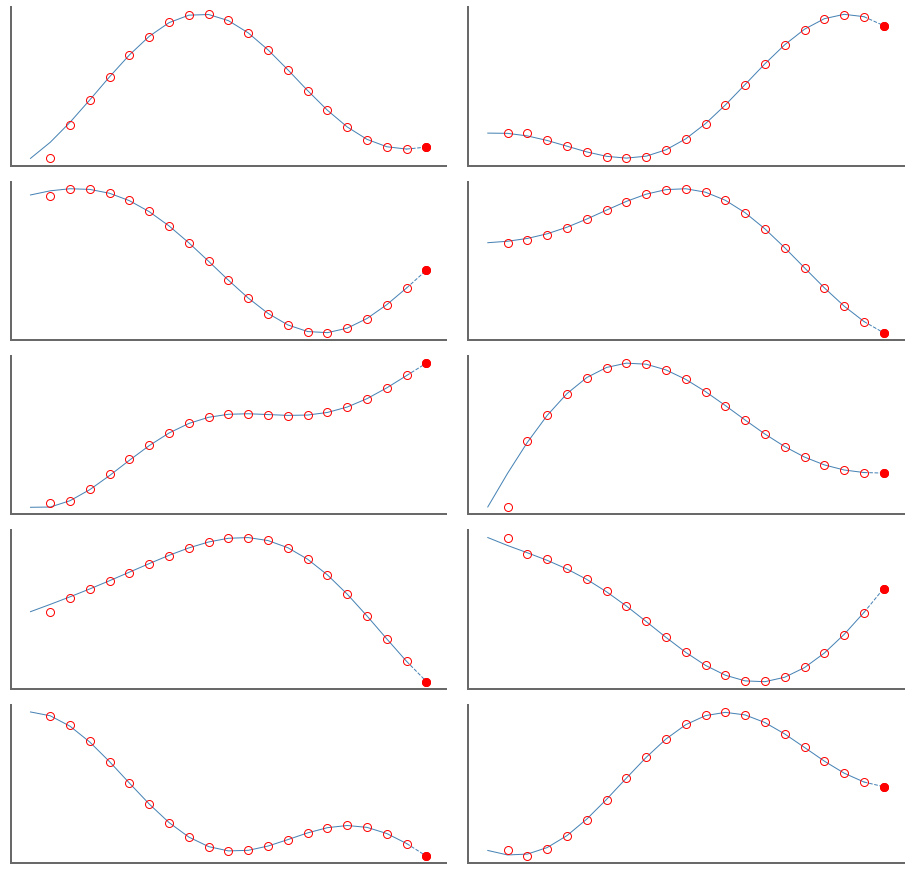

In [8]:
n_series=10

# ----- Récupération du modèle pour effectuer des prédictions
#
tf.reset_default_graph()
saver = tf.train.import_meta_graph(ooo.get_model_dir()+"/model1.meta")

X, y, training, outputs, loss = tf.get_collection("main_model_ops")

# ----- Restauration de la session et prédiction
#
with tf.Session() as sess:
    # ---- Restore session
    saver.restore(sess, ooo.get_model_dir()+"/model1")
    # ---- Get a serie
    X_new, y_new = get_batch(n_series, t_test, t_max, n_steps)
    # ---- Get predictions
    y_pred = sess.run(outputs, feed_dict={X: X_new})

# ----- Visualisation 
#
show_predictions1(n_series, X_new, y_new, y_pred)

### Génération de séquences créatives (Creative generation)

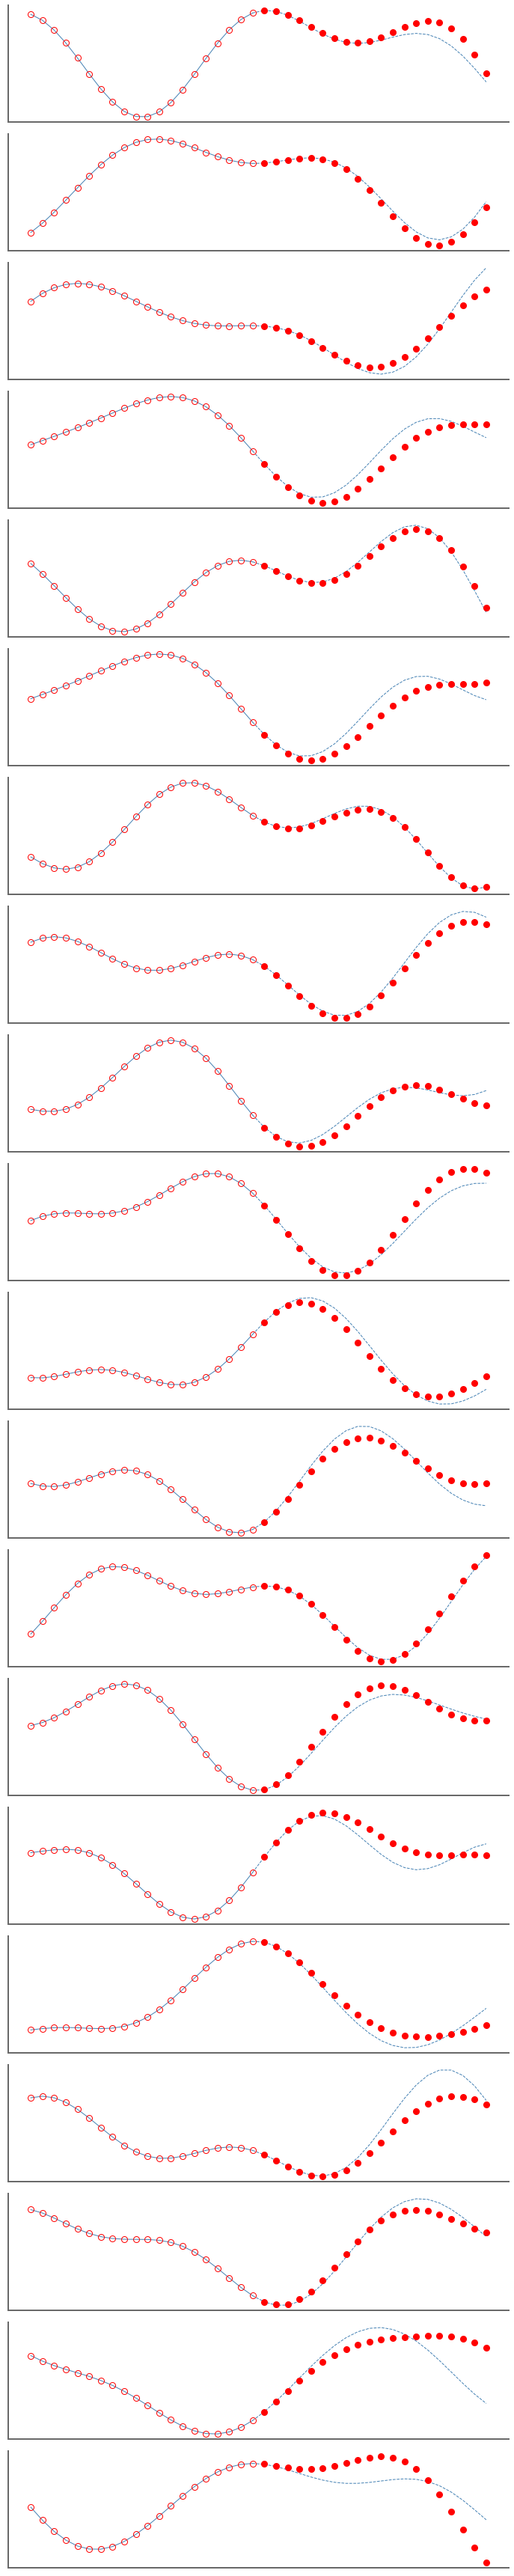

In [9]:

def get_creative_sequence(sequence, n_pred):
    #
    for iteration in range(n_pred):
        # On récupère les n_steps dernieres valeurs
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        # On fait une prédiction
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        # On récupère la dernière valeur de la série prédite
        sequence.append(y_pred[0, -1, 0])
    #
    return sequence

n_series = 20
n_pred   = 20
    
# ---- Get batch : dans l'intervalle [t_test,t_max]
#
X_new, y_new = get_batch(n_series, t_test, t_max, n_steps+n_pred)
sequences=[]

with tf.Session() as sess:
    # Restore model
    saver.restore(sess, ooo.get_model_dir()+"/model1")
    # Get sequences
    for i in range(n_series):
        s_init = X_new[i,0:n_steps,0].tolist()
        s_pred = get_creative_sequence(s_init, n_pred) 
        sequences.append( s_pred )

# ----- Visualisation 
#
show_predictions2(n_series, X_new, y_new, y_pred, n_pred)


### Génération complète

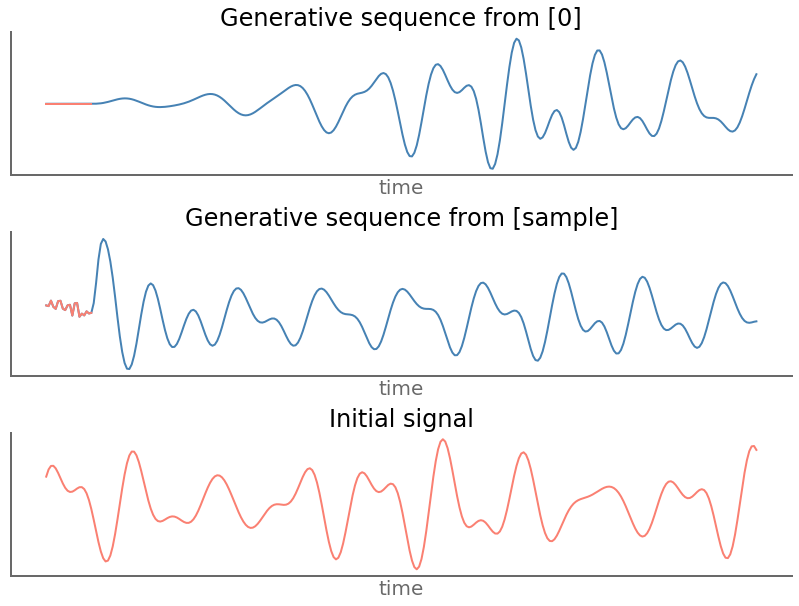

In [10]:
# ------ Get new 
t       = np.arange(t_min, t_train,   resolution)
X_new,y = get_batch(1, t_min,t_train, t.size)

ti = random.randint(0, (t_train-t_min)/resolution -n_steps) 


with tf.Session() as sess:
    # Restore checkpoint
    #
    saver.restore(sess, ooo.get_model_dir()+"/model1")
    
    # Iterate #1
    #
    sequence1 = [0.] * n_steps
    for iteration in range(len(t)-n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    # Iterate #2
    #
#     sequence2 = X_new[0,ti:ti+n_steps,0].tolist()
    sequence2 = (np.random.rand(n_steps)*1.5).tolist()
    for iteration in range(len(t)-n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])


show_generatives(X, sequence1, sequence2, width=14, height=10)
